In [6]:
import pandas as pd
import numpy as np
import random

from functions import train_test

In [2]:
rating_df = pd.read_csv('data/user_rating_pt.csv')
rating_df.columns = rating_df.columns.astype(int)

In [3]:
#filter if a user liked a movie with by a certain rating.
#Values will be 1 if they like a movie, 0 if they don't or have not seen the movie
rating_treshold = 3.5

rating_df[rating_df < rating_treshold] = 0
rating_df[rating_df >= rating_treshold] = 1
rating_df.columns = range(len(rating_df.columns))

rating_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0


In [4]:
rating_matrix = np.array(rating_df)

In [7]:
known = []

for u in range(rating_matrix.shape[0]):
    for i in range(rating_matrix.shape[1]):
        if rating_matrix[u,i] > 0:
            known.append((u, i))

training, testing = train_test(known, test_size=0.3)

In [20]:
train_matrix = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))
test_matrix = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))

for u, i in training:
    train_matrix[u][i] = 1

for u, i in testing:
    test_matrix[u][i] = 1
    
train_matrix = pd.DataFrame(train_matrix)
test_matrix = pd.DataFrame(test_matrix)

In [10]:
def get_metrics(test_set, recommend_list):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for item in recommend_list:
        if item in test_set:
            true_positive += 1
        else:
            false_positive += 1

    for item in test_set:
        if item not in recommend_list:
            false_negative+=1

    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    F1_score = 2*(precision*recall)/(precision + recall)

    print("Precision :", precision)
    print("Recall :", recall)
    print("F1 Score :", F1_score)
    
    return precision, recall, F1_score

In [11]:
def common_neighbors(dataset, by='user'):
    #since values are either 1 or 0, the dot product of two users/movies 
    #is used to find the number of common neighbors 
    if by == 'user':
        common_matrix = np.dot(dataset, dataset.T)
    elif by == 'movie':
        common_matrix = np.dot(dataset.T, dataset)
    
    return pd.DataFrame(common_matrix)


In [12]:
def jacard_coefﬁcient(dataset, by='user'):
    if by == 'user':
        jc = common_neighbors(dataset, by='user')
        sum_matrix = dataset.T.sum()      
        
    elif by == 'movie':
        jc = common_neighbors(dataset, by='movie') 
        sum_matrix = dataset.sum()
        sum_matrix.index = range(len(sum_matrix))
        
    size = len(jc)
    ones_matrix = pd.DataFrame(np.ones((size,size)))
    
    #get size of the union of two users or movies
    union_count = (sum_matrix * ones_matrix).T + (sum_matrix * ones_matrix) - jc
    
    jc = jc/union_count
    
    jc = jc.fillna(0)
    
    return jc

In [13]:
def preferential_attachment(dataset, by='user'):
    if by == 'user':
        sum_matrix = dataset.T.sum()
    elif by == 'movie':
        sum_matrix = dataset.sum()
        sum_matrix.index = range(len(sum_matrix))
        
    ones_matrix = pd.DataFrame(np.ones((len(sum_matrix),len(sum_matrix))))
    pa = sum_matrix * ones_matrix * (sum_matrix * ones_matrix).T

    return pa

In [25]:
def TSUISIMCF(train_data, user_sim, movie_sim, k_user, n_movie, users_evaluated):
    #list of recommeded movies to users
    recommeded_movies = []
    
    for user in users_evaluated:
        #get movies user liked
        movies = train_data.loc[user]
        liked_movies = list(movies[movies == 1].index)
       
        #get top k most similar users
        top_k = list(user_sim.loc[user].sort_values(ascending=False)[:k_user+1].index)
        
        if user in top_k:
            top_k.remove(user)
        else:
            top_k = top_k[:k_user]
        
        #get possible movie recommendations
        possible_rec = []
        
        for top_user in top_k:
            movies = train_data.loc[top_user]
            user_likes = list(movies[movies == 1].index)
                                
            for movie in user_likes:
                if (movie not in liked_movies) and (movie not in possible_rec):
                    possible_rec.append(movie)
        
        #get score of possible recommendations
        rec_scores = []
        
        for movie in possible_rec:
            score = movie_sim.loc[movie, liked_movies].max()
            rec_scores.append(score)
        
        #get top n score index
        top_index = np.argpartition(rec_scores,-n_movie)[-n_movie:]
        
        #get top movie recommendations
        for index in top_index:
            recommeded_movies.append((user, possible_rec[index]))
            
    return recommeded_movies

In [43]:
#get similarities
cn_user = common_neighbors(train_matrix, by='user')
cn_movie = common_neighbors(train_matrix, by='movie')

jc_user = jacard_coefﬁcient(train_matrix, by='user')
jc_movie = jacard_coefﬁcient(train_matrix, by='movie')

pa_user = preferential_attachment(train_matrix, by='user')
pa_movie = preferential_attachment(train_matrix, by='movie')

In [44]:
#cn_user and cn_movie
recommend_list = TSUISIMCF(train_matrix, cn_user, cn_movie, 15, 5, range(train_matrix.shape[0]))

In [50]:
full_results = pd.DataFrame( columns=['user', 'item', 'Prec', 'Rec', 'F1'])

In [51]:
results = get_metrics(testing, recommend_list)
full_results.loc[len(full_results)] = ["Common Neighbors", "Common Neighbors", results[0], results[1], results[2]]

Precision : 0.22819672131147542
Recall : 0.037591142317040235
F1 Score : 0.06454903779271969


In [56]:
full_results

,user,item,Prec,Rec,F1
0,Common Neighbors,Common Neighbors,0.228197,0.037591,0.064549
1,Common Neighbors,Jaccard Coefficient,0.072787,0.011990,0.020589


In [54]:
#cn_user and jc_movie
recommend_list = TSUISIMCF(train_matrix, cn_user, jc_movie, 15, 5, range(train_matrix.shape[0]))
results = get_metrics(testing, recommend_list)

full_results.loc[len(full_results)] = ["Common Neighbors", "Jaccard Coefficient", results[0], results[1], results[2]]

Precision : 0.07278688524590164
Recall : 0.01199027815284904
F1 Score : 0.020588917226988173


In [57]:
#cn_user and pa_movie
recommend_list = TSUISIMCF(train_matrix, cn_user, pa_movie, 15, 5, range(train_matrix.shape[0]))
results = get_metrics(testing, recommend_list)

full_results.loc[len(full_results)] = ["Common Neighbors", "Preferential Attachment", results[0], results[1], results[2]]

Precision : 0.20163934426229507
Recall : 0.03321631109910883
F1 Score : 0.05703686529098075


In [58]:
#jc_user and cn_movie
recommend_list = TSUISIMCF(train_matrix, jc_user, cn_movie, 15, 5, range(train_matrix.shape[0]))
results = get_metrics(testing, recommend_list)

full_results.loc[len(full_results)] = ["Jaccard Coefficient", "Common Neighbors", results[0], results[1], results[2]]

Precision : 0.23901639344262296
Recall : 0.03937348096138266
F1 Score : 0.06760955251565035


In [59]:
#jc_user and jc_movie
recommend_list = TSUISIMCF(train_matrix, jc_user, jc_movie, 15, 5, range(train_matrix.shape[0]))
results = get_metrics(testing, recommend_list)

full_results.loc[len(full_results)] = ["Jaccard Coefficient", "Jaccard Coefficient", results[0], results[1], results[2]]

Precision : 0.14754098360655737
Recall : 0.024304617877396704
F1 Score : 0.04173429167632738


In [60]:
#jc_user and pa_movie
recommend_list = TSUISIMCF(train_matrix, jc_user, pa_movie, 15, 5, range(train_matrix.shape[0]))
results = get_metrics(testing, recommend_list)

full_results.loc[len(full_results)] = ["Jaccard Coefficient", "Preferential Attachment", results[0], results[1], results[2]]

Precision : 0.2137704918032787
Recall : 0.035214690791250336
F1 Score : 0.06046835149547878


In [61]:
#pa_user and cn_movie
recommend_list = TSUISIMCF(train_matrix, pa_user, cn_movie, 15, 5, range(train_matrix.shape[0]))
results = get_metrics(testing, recommend_list)

full_results.loc[len(full_results)] = ["Preferential Attachment", "Common Neighbors", results[0], results[1], results[2]]

Precision : 0.22885245901639345
Recall : 0.03769916284093978
F1 Score : 0.06473452353350335


In [67]:
#pa_user and jc_movie
recommend_list = TSUISIMCF(train_matrix, pa_user, jc_movie, 15, 5, range(train_matrix.shape[0]))
results = get_metrics(testing, recommend_list)

full_results.loc[len(full_results)] = ["Preferential Attachment", "Jaccard Coefficient", results[0], results[1], results[2]]

Precision : 0.07311475409836066
Recall : 0.012044288414798812
F1 Score : 0.020681660097380015


In [68]:
#pa_user and pa_movie
recommend_list = TSUISIMCF(train_matrix, pa_user, pa_movie, 15, 5, range(train_matrix.shape[0]))
results = get_metrics(testing, recommend_list)

full_results.loc[len(full_results)] = ["Preferential Attachment", "Preferential Attachment", results[0], results[1], results[2]]

Precision : 0.2022950819672131
Recall : 0.03332433162300837
F1 Score : 0.05722235103176443


In [69]:
full_results

,user,item,Prec,Rec,F1
0,Common Neighbors,Common Neighbors,0.228197,0.037591,0.064549
1,Common Neighbors,Jaccard Coefficient,0.072787,0.011990,0.020589
2,Common Neighbors,Preferential Attachment,0.201639,0.033216,0.057037
3,Jaccard Coefficient,Common Neighbors,0.239016,0.039373,0.067610
4,Jaccard Coefficient,Jaccard Coefficient,0.147541,0.024305,0.041734
5,Jaccard Coefficient,Preferential Attachment,0.213770,0.035215,0.060468
6,Preferential Attachment,Common Neighbors,0.228852,0.037699,0.064735
7,Preferential Attachment,Jaccard Coefficient,0.073115,0.012044,0.020682
8,Preferential Attachment,Preferential Attachment,0.202295,0.033324,0.057222


# Graphs

In [70]:
import matplotlib.pyplot as plt 

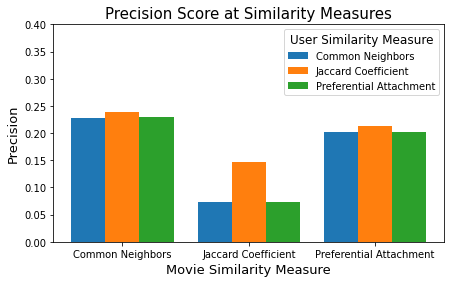

In [127]:
CN = full_results[full_results['user'] == 'Common Neighbors']
JC = full_results[full_results['user'] == 'Jaccard Coefficient']
PA = full_results[full_results['user'] == 'Preferential Attachment']

Xaxis = np.arange(len(CN))

width = 0.27

plt.figure(figsize=(7,4))

plt.bar(Xaxis - width, CN['Prec'], width=width, label='Common Neighbors')
plt.bar(Xaxis, JC['Prec'], width=width, label='Jaccard Coefficient')
plt.bar(Xaxis + width, PA['Prec'], width=width, label='Preferential Attachment')

plt.xticks(Xaxis, CN['item'])
plt.ylim([0, 0.4])

plt.legend(title="User Similarity Measure", title_fontsize='large')

plt.title("Precision Score at Similarity Measures", size=15)
plt.xlabel("Movie Similarity Measure", size=13)
plt.ylabel("Precision", size=13)

plt.show()

In [123]:
recommend_list = TSUISIMCF(train_matrix, jc_user, cn_movie, 15, 8, range(train_matrix.shape[0]))
get_metrics(testing, recommend_list)

Precision : 0.2108606557377049
Recall : 0.0555765595463138
F1 Score : 0.08796751442615942


(0.2108606557377049, 0.0555765595463138, 0.08796751442615942)